In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

In [2]:
events = pd.read_csv("events_WC22.csv", low_memory=False)

euro = events[events['competition_season'] == "UEFA Euro_2020"]
cdm = events[events['competition_season'] == "FIFA World Cup_2022"]
cdm_final = cdm[cdm['match_date'] == "2022-12-18"]

df = cdm_final.sort_index()

## Create the possesion 2

In [3]:
df["possession_2"] = df["possession"].copy()

for i in df["possession_2"].unique():
    sub = df[df["possession_2"] == i]

    if "Shot" in sub["type.name"].unique() and sub["type.name"].value_counts()["Shot"] > 1:
        shot_part = sub[sub["type.name"] == "Shot"].index

        for idx in shot_part[:-1]:
            df.loc[idx+2:, "possession_2"] += 1

## PSV

In [4]:
# Créer une colonne 'PSV' avec des valeurs par défaut de 0
df['PSV'] = .0

# Identifier les indices des tirs dans le dataframe
shoot_indices = df[df['type.name'] == 'Shot'].index

# Calculer le PSV pour chaque séquence de possession
for idx in shoot_indices:
    possession_idx = df.loc[:idx, 'possession_2'].max()
    possession_events = df[df['possession_2'] == possession_idx]

    # Calculer le PSV pour la séquence de possession
    total_xG = possession_events['shot.statsbomb_xg'].astype(float).sum()
    df.loc[df['possession_2'] == possession_idx, 'PSV'] = total_xG

In [5]:
df[["minute","possession", "possession_2", "player.name", "type.name", "PSV", "shot.statsbomb_xg"]].iloc[4050:4070]

,minute,possession,possession_2,player.name,type.name,PSV,shot.statsbomb_xg
36400,107,228,229,Leandro Daniel Paredes,Ball Recovery,0.104072,NaN
36401,107,228,229,Leandro Daniel Paredes,Carry,0.104072,NaN
36402,107,228,229,Leandro Daniel Paredes,Pass,0.104072,NaN
36403,107,228,229,Gonzalo Ariel Montiel,Ball Receipt*,0.104072,NaN
36404,107,228,229,Gonzalo Ariel Montiel,Carry,0.104072,NaN
36405,107,228,229,Gonzalo Ariel Montiel,Pass,0.104072,NaN
36406,107,228,229,Lautaro Javier Martínez,Ball Receipt*,0.104072,NaN
36407,107,228,229,Lautaro Javier Martínez,Pass,0.104072,NaN
36408,107,228,229,Lionel Andrés Messi Cuccittini,Ball Receipt*,0.104072,NaN
36409,107,228,229,Lionel Andrés Messi Cuccittini,Carry,0.104072,NaN


## xT

In [6]:
obv_type= ['Pass', 'Ball Receipt*', 'Carry',
       'Pressure', 'Foul Committed', 'Foul Won', 'Ball Recovery', 'Block',
       'Miscontrol', 'Clearance', 'Duel', 'Interception', 'Dribble',
       'Shot', 'Goal Keeper', 'Dispossessed', 'Dribbled Past','Offside']

In [7]:
df = df[df["type.name"].isin(obv_type)]

In [8]:
df["x"] = df["location"].apply(lambda x: x.split(",")[0][1:]).astype(float)
df["y"] = df["location"].apply(lambda x: x.split(",")[1][:-1]).astype(float)

In [9]:
prob_rows = np.array([
    [0.2, 0.3, 0.3, 0.3, 0.4, 0.4, 0.5, 0.7, 0.8, 1, 1.3, 1.8, 2.5, 3.7, 4.8, 6, 6.6],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.5, 0.7, 0.8, 1.1, 1.5, 2, 2.9, 4.2, 5.6, 7.5, 6.6],
    [0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.6, 0.7, 0.9, 1.2, 1.6, 2.2, 3.4, 4.6, 6.8, 9.4, 10.3],
    [0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.6, 0.7, 0.9, 1.2, 1.6, 2.3, 3.4, 4.6, 6.8, 9.9, 12.3],
    [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.6, 0.7, 1, 1.3, 1.7, 2.5, 3.4, 4.8, 6.8, 12.6, 15.8],
    [0.4, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.8, 0.9, 1.3, 1.7, 2.5, 3.3, 5.2, 8.9, 17.1, 41]
])

# Mirror the probabilities to create a full 12x16 grid
xT_values = np.vstack((prob_rows, np.flipud(prob_rows)))

# Normalize the probabilities to a scale of 0-1 (dividing by 100 since they were given as percentages)
xT_values /= 100

# Function to map location to xT value
def map_location_to_xT(x,y, xT_values):
    # Map the x and y coordinates to the xT grid
    xT_x = min(int(np.floor(float(x) / 120 * 16)), 15)
    xT_y = min(int(np.floor(float(y) / 80 * 12)), 11)
    return xT_values[xT_y, xT_x]

# Apply the function to the DataFrame
df['xT'] = df.apply(lambda row: map_location_to_xT(row['x'], row['y'], xT_values), axis=1)

In [10]:
df.loc[(df["pass.outcome.name"].isnull())& (df["type.name"] == "Pass"), "pass.outcome.name"] = "Complete"
df.loc[(df["pass.outcome.id"].isnull()) & (df["type.name"] == "Pass"), "pass.outcome.id"] = 8.

In [11]:
def get_outcome(row):
    if row["type.name"] == "Pass":
        return row["pass.outcome.name"]
    elif row["type.name"] == "Dribble":
        return row["dribble.outcome.name"]
    elif row["type.name"] == "Shot":
        return row["shot.outcome.name"]
    else:
        return None
    
df["outcome"] = df.apply(get_outcome, axis=1)

In [12]:
def get_end_location(row):
    if pd.notnull(row['pass.end_location']):
        return row['pass.end_location']

    elif pd.notnull(row['shot.end_location']):
        return row['shot.end_location']

    elif pd.notnull(row['carry.end_location']):
        return row['carry.end_location']

    elif row["type.name"] == "Dribble":
        # return end_location of next event
        row_index = row.name
        next_index = row_index + 1

        if next_index in df.index:  # Vérifie si le prochain index existe
            next_event = df.loc[next_index]
            return next_event.get("carry.end_location")
    else:
        return None

def remove_brackets(x):
    if x[-1] == "]":
        return x[:-1]
    elif x[0] == "[":
        return x[1:]
    else:  
        return x

df['end_location'] = df.apply(get_end_location, axis=1)
df['end_x'] = df.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[0])) if pd.notnull(row['end_location']) else None, axis=1)
df['end_y'] = df.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[1])) if pd.notnull(row['end_location']) else None, axis=1)

df['end_z'] = df.apply(lambda row: float(remove_brackets(row['end_location'].split(",")[-1])) if pd.notnull(row['end_location']) and row['type.name'] == 'Shot' else 0, axis=1)


df['xT.end'] = df.apply(lambda row: map_location_to_xT(row['end_x'], row['end_y'], xT_values) if pd.notnull(row['end_location']) else None, axis=1)

In [13]:
df.iloc[230:240][["type.name", "player.name", "outcome", "end_location", "carry.end_location", "end_x", "end_y", "end_z", "xT", "xT.end"]]

,type.name,player.name,outcome,end_location,carry.end_location,end_x,end_y,end_z,xT,xT.end
32584,Carry,Theo Bernard François Hernández,None,"[54.2, 15.1]","[54.2, 15.1]",54.2,15.1,0.0,0.010,0.007
32585,Pressure,Rodrigo Javier De Paul,None,None,NaN,NaN,NaN,0.0,0.004,NaN
32586,Pressure,Enzo Fernandez,None,None,NaN,NaN,NaN,0.0,0.008,NaN
32587,Dribbled Past,Enzo Fernandez,None,None,NaN,NaN,NaN,0.0,0.009,NaN
32588,Dribble,Theo Bernard François Hernández,Complete,"[46.5, 34.4]",NaN,46.5,34.4,0.0,0.007,0.006
32589,Carry,Theo Bernard François Hernández,None,"[46.5, 34.4]","[46.5, 34.4]",46.5,34.4,0.0,0.007,0.006
32590,Pass,Theo Bernard François Hernández,Complete,"[40.7, 54.7]",NaN,40.7,54.7,0.0,0.006,0.005
32591,Ball Receipt*,Jules Koundé,None,None,NaN,NaN,NaN,0.0,0.005,NaN
32592,Carry,Jules Koundé,None,"[37.9, 54.7]","[37.9, 54.7]",37.9,54.7,0.0,0.005,0.005
32593,Pass,Jules Koundé,Complete,"[34.5, 34.8]",NaN,34.5,34.8,0.0,0.005,0.005


In [14]:
df = df[df["type.name"] != "Ball Receipt*"]

## Model

In [15]:
df.fillna(0, inplace=True)
df = df[df["period"] <= 4]

/tmp/ipykernel_658323/3747663188.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


In [16]:
# Select the columns to drop
column_name = df.columns[df.columns.str.endswith("name")]
end_location = df.columns[df.columns.str.endswith("end_location")]
to_drop = [*column_name, *end_location] + ["id", "index", "match_id", "match_date", 
                                           "match_outcome", "minute", "second", "possession", 
                                           "competition_season", "timestamp", 
                                           "tactics.lineup", "related_events", "location", "PSV", "shot.statsbomb_xg", "shot.aerial_won"]


# Select the features and the target
X = df.drop(to_drop, axis=1)
y = df["PSV"]

In [17]:
# Transform the categorical variables into numerical variables
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = pd.Categorical(X[col]).codes

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the PSV
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Mean Squared Error: 0.001516079719196421


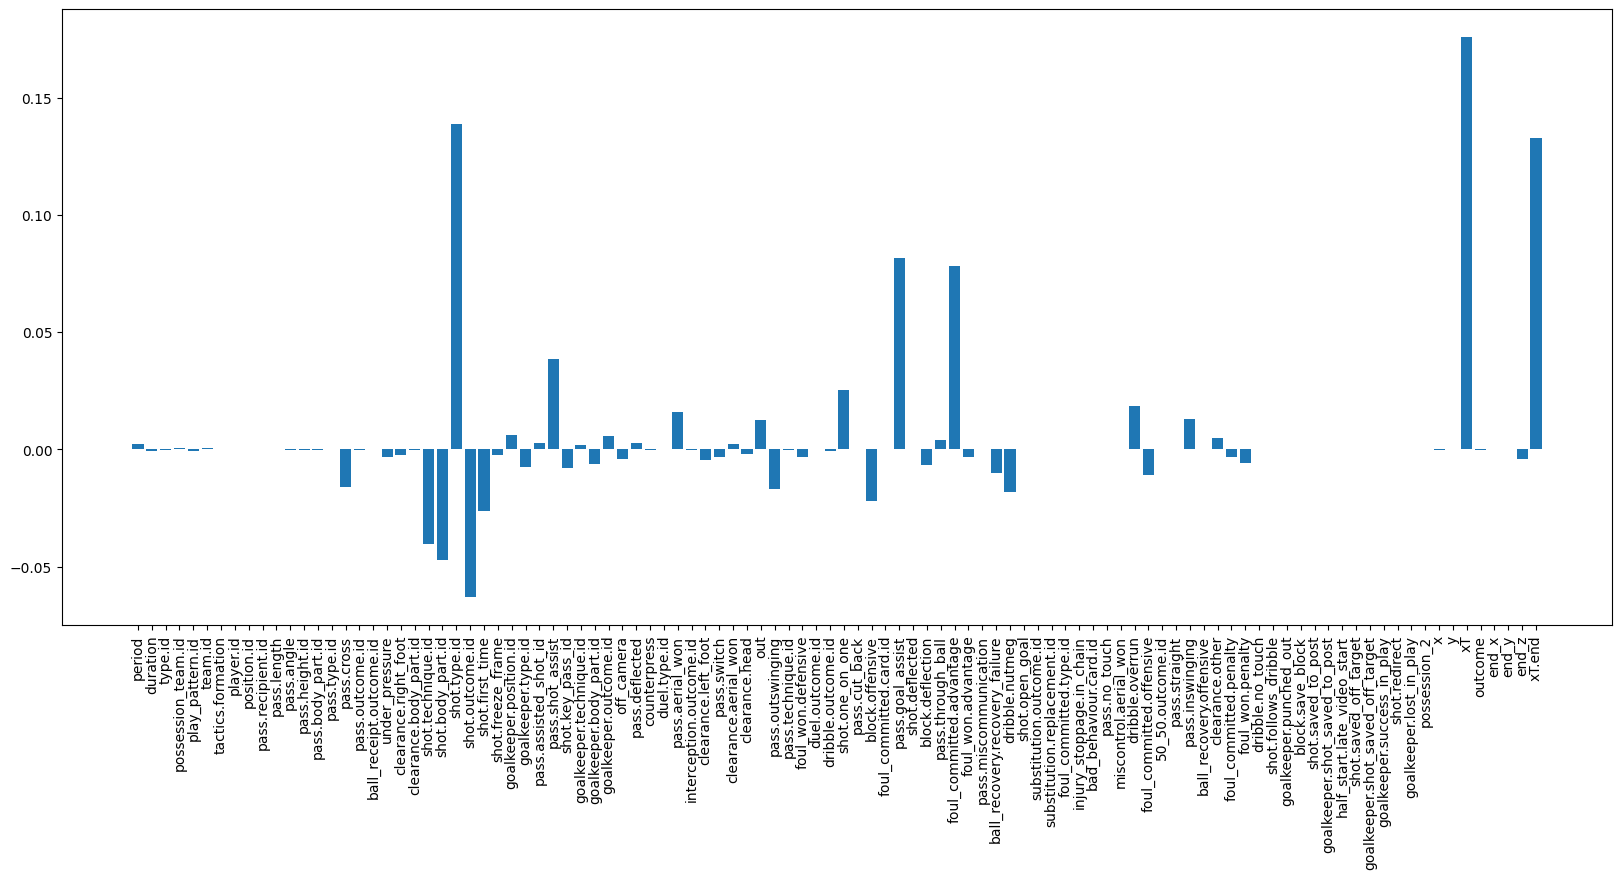

In [19]:
# Plot the coefficients of linear regression
plt.figure(figsize=(20, 8))
plt.bar(X.columns, model.coef_)
plt.xticks(rotation=90)
plt.show()

In [20]:
df["type.name"].value_counts()  

type.name
Pass              1263
Carry              940
Pressure           361
Ball Recovery      115
Duel                98
Dribble             54
Block               50
Foul Committed      48
Clearance           45
Foul Won            44
Goal Keeper         36
Miscontrol          35
Dispossessed        34
Dribbled Past       31
Shot                30
Interception        28
Offside              1
Name: count, dtype: int64

In [21]:
r2_score(y_test, y_pred)

0.35161410509988866

In [22]:
X_test["pred"] = y_pred

In [23]:
X_test

,period,duration,type.id,possession_team.id,play_pattern.id,team.id,tactics.formation,player.id,position.id,pass.recipient.id,...,possession_2,x,y,xT,outcome,end_x,end_y,end_z,xT.end,pred
33055,1,1.324455,30,779,3,779,0.0,2995.0,21.0,3090.0,...,31,65.5,2.5,0.008,2,51.2,14.5,0.0,0.006,0.002044
35811,3,1.493448,30,779,1,779,0.0,5507.0,6.0,27886.0,...,198,42.2,5.3,0.004,2,40.7,13.6,0.0,0.004,0.028677
32839,1,0.000000,39,779,8,771,0.0,3026.0,11.0,0.0,...,23,33.6,62.6,0.004,0,0.0,0.0,0.0,0.000,-0.006217
33862,1,1.370070,43,771,3,771,0.0,10481.0,9.0,0.0,...,66,84.3,59.0,0.023,0,86.0,55.1,0.0,0.023,0.004112
35635,2,0.448166,17,779,1,771,0.0,22097.0,22.0,0.0,...,185,116.0,36.1,0.171,0,0.0,0.0,0.0,0.000,0.031210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32856,1,1.568642,43,771,3,771,0.0,5477.0,17.0,0.0,...,24,89.0,74.4,0.018,0,89.5,75.9,0.0,0.018,0.003747
35052,2,1.046513,30,771,1,771,0.0,24778.0,6.0,8519.0,...,143,45.2,2.7,0.005,2,35.1,11.5,0.0,0.004,-0.003854
32395,1,1.638329,30,779,3,779,0.0,3090.0,5.0,20572.0,...,5,29.8,29.2,0.004,2,27.0,45.9,0.0,0.005,0.000421
36048,3,0.742339,30,779,3,779,0.0,38718.0,10.0,7797.0,...,208,39.8,35.7,0.006,2,53.7,42.3,0.0,0.008,0.016861


In [24]:
pd.set_option('display.max_columns', None)

## Cross Validation

In [25]:
y_cv = cross_val_predict(model, X_train, y_train, cv=5)

In [26]:
mean_squared_error(y_train, y_cv)

0.002158090504044677

In [27]:
r2_score(y_train, y_cv)

0.18526316222212225